In [1]:
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

import image_handler
from model import MSCNN

In [2]:
image_handler.load_image('mall_dataset/frames/seq_000001.jpg', new_shape=(244, 244)).shape

(244, 244, 3)

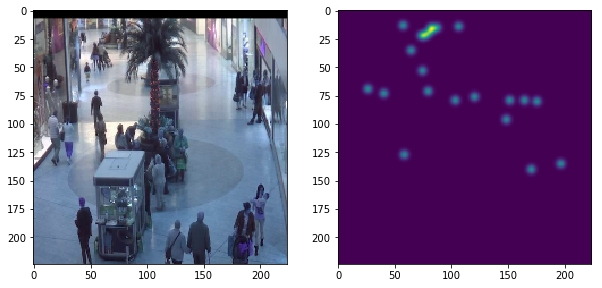

In [3]:
x, y = image_handler.load_images()

image_handler.plot_images(x[1], y[1])

In [5]:
annots, counts = image_handler.load_annotations('mall_dataset/mall_gt.mat')

In [7]:
annots['seq_000001.jpg']

array([[126.77986348,  60.70477816],
       [116.95051195,  47.59897611],
       [175.10750853,  44.3225256 ],
       [184.11774744,  45.14163823],
       [192.30887372,  44.3225256 ],
       [230.80716724,  42.68430034],
       [190.67064846,  66.43856655],
       [176.74573379,  70.53412969],
       [134.97098976, 100.0221843 ],
       [ 14.56143345, 215.51706485],
       [ 57.1552901 , 229.44197952],
       [148.07679181, 193.40102389],
       [143.16211604, 236.81399317],
       [210.32935154, 222.8890785 ],
       [260.29522184, 221.25085324],
       [348.75938567, 225.34641638],
       [364.3225256 , 253.19624573],
       [331.55802048, 249.10068259],
       [136.60921502, 370.32935154],
       [330.73890785, 453.87883959],
       [387.25767918, 433.40102389],
       [397.08703072, 315.44880546],
       [531.42150171, 324.45904437],
       [563.3668942 , 299.88566553],
       [581.38737201, 300.70477816],
       [566.64334471, 140.15870307],
       [524.04948805, 122.13822526],
 

In [8]:
counts['seq_000001.jpg']

29

In [ ]:
input_shape=(128, 128, 3)

model = MSCNN(input_shape)
model.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
opt = SGD(lr=1e-5, momentum=0.9, decay=0.0005)
model.compile(optimizer=opt, loss='mse')

model.fit(x_train, y_train, epochs=30, batch_size=256, validation_split=0.1, verbose=1)

scores = model.evaluate(x_test, y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])